# Artificial Bee Colony (ABC) for the TSP

* **File:** ABC_algorithm_TSP.ipynb
* **Author:** Angel Sanz Gutierrez
* **Contact:** sanzangel017@gmail.com
* **GitHub:** AngelS017
* **Description:** All the code of the proyect, the study and the final conclusions
* **Version:** 1.0

This file is part of ABC algorithm for TSP, which is licensed under the MIT License.
See the LICENSE file in the project root for more information.


Now you will see a brief explanetion about how it works the ABC algorithm, the original paper was written by Karaboga, 2005. We need to take into account that the original 
algorithm was developed for optimizations of continuous problems but in the Travel Salesman Problem (TSP) we are working with discrete optimizations, as we need to optimize 
a route from different cities.

That´s why the pseudocode of the algorithm is not the same as in the original paper.


Explanation of the algorithm:
1. Initialize the population:

    Each bee will create a random path and calculate its distance and all other necessary parameters.
    Also the bees will have a role assigned.

2. While the number of epochs is not reached:
    1. Employed bee behaviour:
        
        The bees that have the rol of employed will generate a new solution and if the new solution it´s better than the old one the bee will update its path and distance path.  

    2. Calculate the probability of each solution:
        
        All the solutions will have a probability to be choosed in the next phase of the algorithm, to calculate the probability we need to divide the distance  of each solution 
        by the sum of all distance paths.

    3. Onlooker bee behaviour:

        The bees that have the rol of onlooker will choose the best solution using the roulette wheel selection and a new solution its generated and if the new solution  it is better than the old one the bee will update its path and distance path.

    4. Scout bee behaviour:

        If a bee has reached the number of trials to work with a solution, it will be eliminated and a new one will be generated with a randomised path.

3. Report the best path found and the distance of that path


> [!NOTE]: Generate new solutions
> To generate a new solutions in the TSP there are different technics, thats the idea of the project, create an ABC algorithm to work with a bounch of them.

## Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance # for euclidian distance

import abc_tsp

## Read dataset

The data that we are going to use in this proyect will be obtein from a web call [National TSP](https://www.math.uwaterloo.ca/tsp/world/countries.html) from the University of Waterloo.

Each dataset conteins a  number of cities which are represented with their X and Y coordinates.


In this case we are going to work with the dataset of the country Luxembourg.

In [5]:
cities = pd.read_csv("data/lu980.tsp", sep=" ", skiprows=7, header=None, names=["Coord X", "Coord Y"])
cities = cities.iloc[:-1]
print("In our dataset there are {0} cities".format(cities.shape[0]))
cities

In our dataset there are 980 cities


,Coord X,Coord Y
1,49525.5556,5940.5556
2,49525.5556,5940.5556
3,49738.8889,6345.0000
4,49608.3333,6405.8333
5,49796.6667,6155.5556
...,...,...
976,50108.0556,5923.3333
977,49880.2778,6221.9444
978,49894.4444,6163.6111
979,49926.6667,6173.6111


## Clean dataset

Our dataset contains 980 cities, but there are some duplicate cities. So after the removal of the duplicate cities, because of the travelling salesman problem, the path can only pass through each city once, 634 cities would be left.

In [6]:
cities_duplicated = cities.duplicated().sum()
print("Number of duplicated cities: ", cities_duplicated)

cities = cities.drop_duplicates()
cities = cities.reset_index(drop=True)
print("\nIn our dataset there are {0} cities after delating the duplicated cities".format(cities.shape[0]))

Number of duplicated cities:  346

In our dataset there are 634 cities after delating the duplicated cities


## Create matrix distance between cities

The cost of traveling between cities is specified by the **Euclidean distance** rounded to the nearest whole number.

In [7]:
distance_matrix = np.round(distance.cdist(cities, cities, 'euclidean')).astype(int)
print("Shape distance matrix: ", distance_matrix.shape)
distance_matrix

Shape distance matrix:  (634, 634)


array([[  0, 457, 473, ..., 162, 414, 402],
       [457,   0, 144, ..., 355, 208, 501],
       [473, 144,   0, ..., 332,  93, 614],
       ...,
       [162, 355, 332, ...,   0, 261, 490],
       [414, 208,  93, ..., 261,   0, 617],
       [402, 501, 614, ..., 490, 617,   0]])

## Other functions

In [8]:
def history_best_paths_distances(paths_distances, employed_strategy, onlooker_strategy, xlabel='Epochs', ylabel='Best path distances', title='Evolution of path distances'):
    """Plot the distance of the best path found in each epoch during the training.

     Parameters
     ----------
     paths_distances : array-like
          The distance of the best path of each epoch during the training process.
          
     employed_strategy : str
          The stategy use in the employed bees behaviour.
     
     onlooker_strategy: str
          The stategy use in the onlooker bees behaviour.
     
     xlabel : str, default=Epochs
          The name to put in the xlabel of the plot.

     ylabel : str, default=Best path distances
          The name to put in the ylabel of the plot.

     title : str, default=Evolution of path distances
          The title of the plot.

     Returns
     -------

     """
    plt.plot(paths_distances)
    plt.scatter(np.argmin(paths_distances), np.min(paths_distances), color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([f'Min distance: {np.min(paths_distances)}'])
    plt.text(1.05, 0.5, 
         f"Employed strategy:\n{employed_strategy}\n\n"
         f"Onlooker strategy:\n{onlooker_strategy}",
         transform=plt.gca().transAxes,
         verticalalignment='center', 
         horizontalalignment='left',
         fontsize=10,
         fontstyle='normal',
         bbox=dict(facecolor='#f0f0f0', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.9))
    plt.show

In [9]:
def info_training(block_size, paths_distances):
    """Plot 

    Parameters
    ----------
    block_size : int
        The number of iterations in each block. The training process is divided into blocks of this size 
        to calculate and analyze the improvements.
  
    paths_distances : array-like
        The distance of the best path of each epoch during the training process.
    
    Returns
    -------

    """
    improvements = []
    percent_improvements = []

    for block_ini in range(0, len(paths_distances)-block_size, block_size):
        block_end = block_ini + block_size

        start_distance_path = paths_distances[block_ini]
        end_distance_path = paths_distances[block_end]

        improvement_distance = start_distance_path- end_distance_path
        percentaje_improvement = (improvement_distance / start_distance_path) * 100

        print(f"Iterations {block_ini}-{block_end-1}: Improvement of {improvement_distance:.2f} units of distance "
          f"({percentaje_improvement:.2f}%)")

        improvements.append(improvement_distance)
        percent_improvements.append(percentaje_improvement)

    total_improvement = paths_distances[0] - paths_distances[-1]
    total_percent_improvement = (total_improvement / paths_distances[0]) * 100
    print(f"\nTotal improvement over the entire training: {total_improvement:.2f} units of distance "
        f"({total_percent_improvement:.2f}%)")
    
    block_indices = np.arange(len(improvements)) * block_size

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(block_indices, improvements, marker='o', color='blue')
    plt.title('Improvement by Block (Absolute)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (units of distance)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    plt.subplot(1, 2, 2)
    plt.plot(block_indices, percent_improvements, marker='o', color='green')
    plt.title('Improvement by Block (Percentage)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    for i, txt in enumerate(percent_improvements):
        plt.text(block_indices[i], percent_improvements[i], f'{txt:.2f}%', fontsize=7, ha='left', va='bottom')

    plt.tight_layout()
    plt.show()

The website provides information on the optimal solution, among other things:
* **Optimal value (min path distance):** 11340
* **Algorithm:** concorde (default settings), QSopt LP solver
* **Time:** 1681.68 seconds, AMD Athlon 1.33 GHz

This will facilitate a comparison with our solution, enabling an informed decision to be made regarding the optimal choice in each particular case, taking into account factors such as the precision required for the problem and the time taken to find the solution.

In [10]:
def plot_comparison(best_solution, other_solution):
   """Plot a comparison between the best solution found for the TSP and another solution.
      There will be 2 types of graphics, in the first one it will compare the time taken to found the solution
      and will appear a pocentage that indicate the difference between the 2 solutions (lower is better, negative indicates 
      that the other solution is x% better than the best one) and the other graphic will compare the distance of the best path and will appear a 
      pocentage that indicate the difference between the 2 solutions (lower is better, possitive indicates that the distance path of the other
      solution is x% worst tahn the best one).

   Parameters
   ----------
   best_solution : tuple (float, float)
      Will contein the best time and the best path distance of the best algorithm.
         
   other_solution : tuple (float, float)
      Will contein the best time and the best path distance of the solution that we want to compare.
   
   Returns
   -------

   """
   best_time, best_path_distance = best_solution
   time, path_distance = other_solution

   time_loss = ((time - best_time) / best_time) * 100
   distance_loss = ((path_distance - best_path_distance) / best_path_distance) * 100
   
   categories_x = ['Execution Time', 'Path Distance']
   categories_y = ['Seconds', 'Distance']
   best_values = [best_time, best_path_distance]
   other_values = [time, path_distance]
   losses = [time_loss, distance_loss]
   
   fig, axes = plt.subplots(1, 2, figsize=(12, 6))
   bar_width = 0.15
   index = np.arange(len(categories_x))
   
   # Create all bars for the data
   axes[0].bar(index[0] - bar_width/2, best_values[0], bar_width, color='darkblue', label='Best Solution')
   axes[0].bar(index[0] + bar_width/2, other_values[0], bar_width, color='dodgerblue', label='Other Solution')

   axes[1].bar(index[1] - bar_width/2, best_values[1], bar_width, color='darkblue', label='Best Solution')
   axes[1].bar(index[1] + bar_width/2, other_values[1], bar_width, color='dodgerblue', label='Other Solution')

   # Add the porcentaje of difference into other solution bar
   axes[0].text(index[0] + bar_width/2, other_values[0] + 0.05 * best_values[0], f'{losses[0]:.1f}%', ha='center', va='bottom', fontsize=12)
   axes[1].text(index[1] + bar_width/2, other_values[1] + 0.005 * best_values[1], f'{losses[1]:.1f}%', ha='center', va='bottom', fontsize=12)
   
   # Set the limints of the axe x to plot both bars in the middle
   axes[0].set_xlim(index[0] - bar_width * 3, index[0] + bar_width * 3)
   axes[1].set_xlim(index[1] - bar_width * 3, index[1] + bar_width * 3)

   for i, ax in enumerate(axes):
      ax.set_xlabel(categories_x[i])
      ax.set_ylabel(categories_y[i])
      ax.set_xticks([])
      ax.legend()

   axes[0].set_title('Execution Time Comparison')
   axes[1].set_title('Path Distance Comparison')
   
   plt.tight_layout()
   plt.show()

In [11]:
import random
import itertools
import time
random.seed(1234)

num_cities = distance_matrix.shape[0]
other_cities = np.delete(np.arange(num_cities), 0)
random_path = np.insert(np.random.permutation(other_cities), [0, len(other_cities)], 0)

path = random_path[:]
len_path = len(path) - 2
k = 3

random_index = sorted(random.sample(range(1, len_path), k))

start = time.time()
for _ in range(10000):
    

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_1 = new_path[1:]
end = time.time()
print(end-start)
#print(new_path_1)

start = time.time()
for _ in range(10000):

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_3 = new_path[1:]
end = time.time()
print("\n", end-start)
#print(new_path_3)

print(np.array_equal(new_path_1,new_path_3))

0.13408827781677246

 0.40094828605651855
True


## Train ABC model

In [9]:
ini_end_city = 0

population = 10
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 20000
epochs = 100000

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
k_employed = 5
k_onlooker = 5

ABC = abc_tsp.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
print(len(final_best_path))

Training Progress: 100%|██████████| 100000/100000 [02:57<00:00, 562.30epoch/s]


Params:
	(ini_end_city=0, population=10, epochs=100000, limit=20000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  13291
The best path found is: 
 [  0 595 133 593 239 158 102 427 274  91 293 163 237 360 289 575 493 356
  21 271 453  20 248 101 621 201  98   3 192 316 244 167 469 307 525 458
  80 283  90  31 587 342 277 413 265 290 218  68  64 613 459 437 528 514
 355 478 540  42 468  18 187 110 419 530  24 598 304 125 580 454 414 557
  51 412 517 252 249 189 246 193 214  25 537 615 114 247 292 370 369 372
 320 186 210 105 432 509 336 147 264 339 254 626 303  15 169 486 330 327
  89 394 516 555 472 480  36  14 208 204 545 124 542 428 521 206 572 171
  69 397 396 222 473 476 384 418 552 148  50 475 446  81  92 321 160 281
 366  43 202 272 312 129 196 173 374 175 400 131   4 450 566 130 582 245
 619 288 392 220 315 262 409 286 565 354 298 260 633 340 199  11 411 106
  62 594 570 539 614 561 449  71  63 403 460  40  67 365  84 507 568 209
 108 185 627  60  59 522 

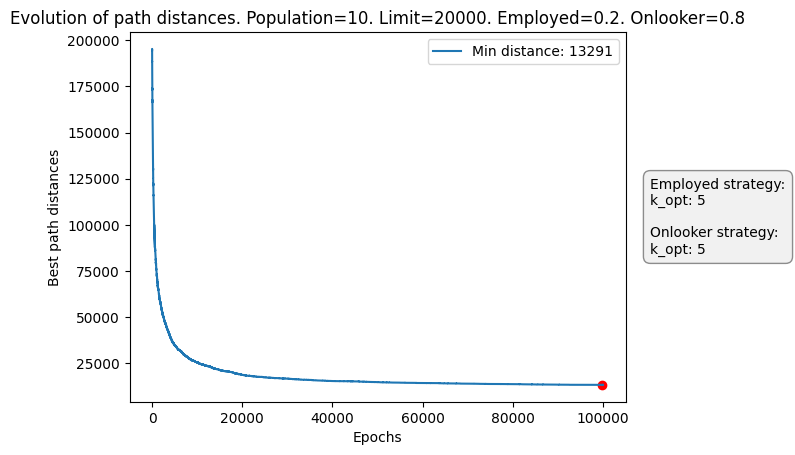

In [10]:
title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'


history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

Iterations 0-5999: Improvement of 162335.00 units of distance (83.42%)
Iterations 6000-11999: Improvement of 8595.00 units of distance (26.63%)
Iterations 12000-17999: Improvement of 3700.00 units of distance (15.63%)
Iterations 18000-23999: Improvement of 2321.00 units of distance (11.62%)
Iterations 24000-29999: Improvement of 971.00 units of distance (5.50%)
Iterations 30000-35999: Improvement of 866.00 units of distance (5.19%)
Iterations 36000-41999: Improvement of 494.00 units of distance (3.12%)
Iterations 42000-47999: Improvement of 411.00 units of distance (2.68%)
Iterations 48000-53999: Improvement of 360.00 units of distance (2.41%)
Iterations 54000-59999: Improvement of 238.00 units of distance (1.64%)
Iterations 60000-65999: Improvement of 226.00 units of distance (1.58%)
Iterations 66000-71999: Improvement of 148.00 units of distance (1.05%)
Iterations 72000-77999: Improvement of 180.00 units of distance (1.29%)
Iterations 78000-83999: Improvement of 154.00 units of dista

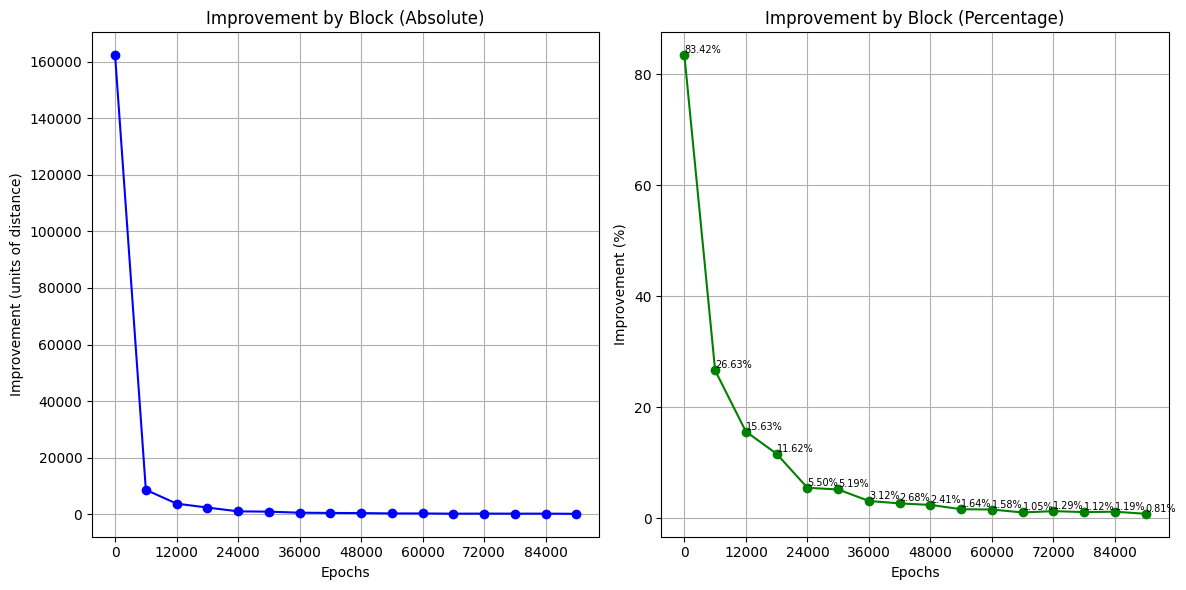

In [11]:
info_training(6000, paths_distances)

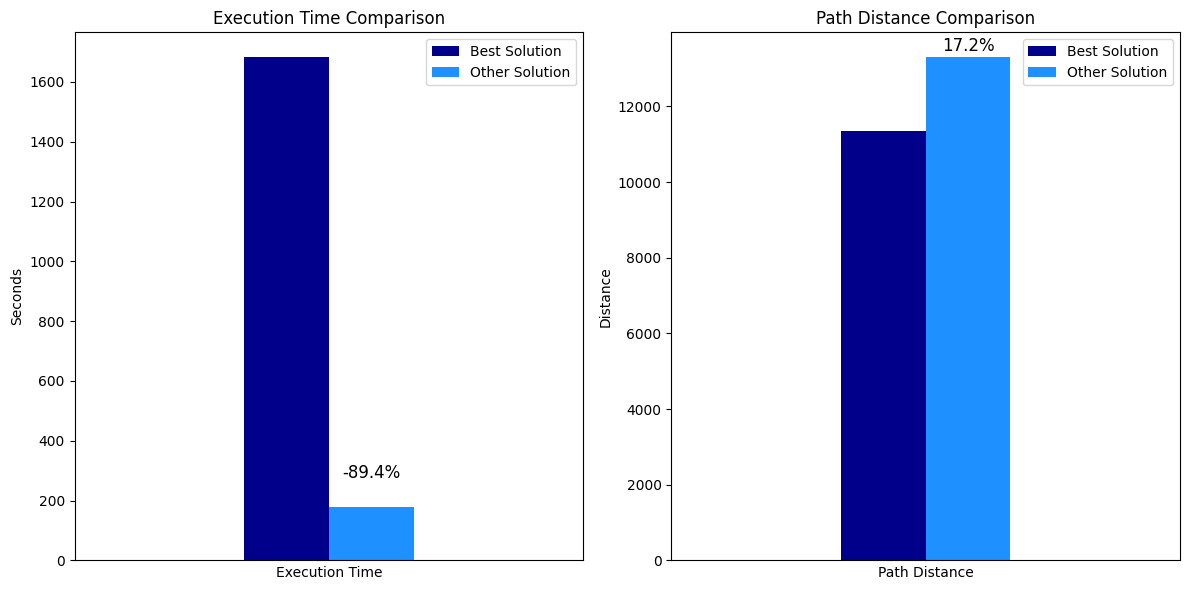

In [12]:
best_solution = [1681.68, 11340]
other_solution = [execution_time, final_best_path_distance]
plot_comparison(best_solution, other_solution)

In [22]:
import itertools
from joblib import Parallel, delayed


def run_simgle_params(ini_end_city, distance_matrix, params):

    abc_optimizer = abc_tsp.ArtificialBeeColonyOptimizer(
    ini_end_city=ini_end_city,
    population=params["population"],
    employed_percentage=params["employed_percentage"],
    limit=params["limit"],
    epochs=params["epochs"],
    distance_matrix=distance_matrix,
    employed_mutation_strategy=params["employed_mutation_strategy"],
    onlooker_mutation_strategy=params["onlooker_mutation_strategy"],
    k_employed=params["k_employed"],
    k_onlooker=params["k_onlooker"],
    verbose=0
    )

    _, _, final_best_path, final_best_path_distance = abc_optimizer.fit()

    return params, final_best_path, final_best_path_distance

def grid_search_abc(distance_matrix, ini_end_city, param_grid, n_jobs=1):
    best_distance = np.inf
    best_params = None
    best_path = None

    keys = param_grid.keys()
    values = param_grid.values()

    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = Parallel(n_jobs=n_jobs)(delayed(run_simgle_params)(ini_end_city, distance_matrix, params) for params in combinations)

    for params, path, distance in results:
        if distance < best_distance:
            best_distance = distance
            best_params = params
            best_path = path
    
    return best_params, best_distance, best_path

In [25]:
ini_end_city = 0

# Definir los hiperparámetros a explorar
param_grid = {
    "population": [50, 100],
    "employed_percentage": [0.5, 0.7],
    "limit": [100, 200],
    "epochs": [1000, 2000],
    "employed_mutation_strategy": ['swap', 'insertion'],
    "onlooker_mutation_strategy": ['swap', 'insertion'],
    "k_employed": [2, 3],
    "k_onlooker": [2, 3]
}

# Ejecutar la búsqueda de hiperparámetros en paralelo
best_params, best_distance, best_path = grid_search_abc(
    distance_matrix=distance_matrix,
    ini_end_city=ini_end_city,
    param_grid=param_grid,
    n_jobs=4
)

print("Mejores hiperparámetros encontrados:", best_params)
print("Mejor camino encontrado:", best_path)
print("Distancia del mejor camino:", best_distance)


Training Progress: 100%|██████████| 2000/2000 [00:04<00:00, 478.06epoch/s]

Mejores hiperparámetros encontrados: {'population': 100, 'employed_percentage': 0.7, 'limit': 100, 'epochs': 2000, 'employed_mutation_strategy': 'insertion', 'onlooker_mutation_strategy': 'insertion', 'k_employed': 2, 'k_onlooker': 2}
Mejor camino encontrado: [  0 510 191 310 212 414 530 435 603 253  12 277 432 307  17 425 421 287
 271  97 443 627 149 585 102  91 349 244 176 317 203  33  45 238  32 569
 538 401 520 449  15 173  60 139 383 534 609 438 584  20 146 419  34 471
  83 431 128 135  72 143 276 367   8 208 347 218 386 479 618 213 188 592
 526 290 440 548 601  52 283 126  87  42 295 234 486  11 223 155   1 498
 465 572  70 190 258 132 550 158 557 469 355 540 456 484 594 351 304 300
   6 596 226 375 474 508  51 289 554 615  56 424 608 323 444 404 527  71
 518  67 327 542 227 551 358 442 113 459 528 167 163 325 602 416 410 546
 267 427 237 489 189 216 339 599 296 232  65 612 625 396 397 466 457 462
 604 302 434 556 553 624 589 166  39 559 607 501 160 278  66 369  24 311
 261 103 1

## Find best hyper parameters

In [14]:
ini_end_city = 0

populations = np.arange(25, 100, step=25)
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 2000
num_epochs = np.arange(10000, 60000, step=10000)

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
num_k = np.arange(4, 9)

num_experiments = len(populations) * len(num_epochs) * len(num_k)
print(f"Number of experiments: {num_experiments}")

Number of experiments: 75


In [15]:
for population in populations:
    for epochs in num_epochs:
        for k_employed in num_k:
            k_onlooker = k_employed

            ABC = abc_tsp.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

            execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
            
            title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'
            history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

            info_training(2000, paths_distances)

            best_solution = [1681.68, 11340]
            other_solution = [execution_time, final_best_path_distance]
            plot_comparison(best_solution, other_solution)

Training Progress:  62%|██████▏   | 6171/10000 [00:15<00:09, 401.42epoch/s]


KeyboardInterrupt: 

## References

Karaboğa, D. (2005). *An idea based on honey bee swarm for numerical optimization*. Technical Report-TR06, Erciyes University, Engineering Faculty, Computer Engineering Department.